In [30]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries
%matplotlib inline
import matplotlib.pyplot as plt
from shapely.ops import cascaded_union
from shapely.geometry import Point, LineString, Polygon
from functools import partial
import pyproj
from shapely.ops import transform
import numpy as np
from geopandas import GeoDataFrame

import requests
import json
import getpass

In [2]:
interlagos = gpd.read_file("../../../data/Cidade de São Paulo/Interlagos/interlagos.geojson")

In [71]:
pista = gpd.read_file("../../../../TESTES - Automating the Project/interlagos.geojson")

## Getting the buffer of Interlagos

In [47]:
#this function is called only if the lat, lon point given is from a building
#receives the polygon of the building
#output: gdf of buffer area of the building (dist=0.003)
def get_buffer(building):
    buffer_building = building.buffer(distance=0.007)
    
    distance = 0.00125
    
    #making buffer a geodataframe
    buffer_gdf = gpd.GeoDataFrame(buffer_building)
    
    #setting buffer's geometry
    geometria = building['geometry'].buffer(distance) 
    buffer_gdf.set_geometry(geometria, inplace=True)
    
    return(buffer_gdf)

In [48]:
buffer_interlagos = get_buffer(interlagos)

C:\Users\gabri\AppData\Local\Temp\ipykernel_14548\2087438035.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer_building = building.buffer(distance=0.007)
C:\Users\gabri\AppData\Local\Temp\ipykernel_14548\2087438035.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometria = building['geometry'].buffer(distance)


In [15]:
buffer_interlagos["poly_type"] = "core"
buffer_interlagos['ID'] = np.arange(len(buffer_interlagos))
buffer_interlagos.set_index('ID', inplace=True)
buffer_interlagos = buffer_interlagos[["poly_type", "geometry"]]

In [16]:
buffer_interlagos

,poly_type,geometry
ID,,
0,core,"POLYGON ((-46.70438 -23.70226, -46.70443 -23.7..."


## Getting Grid Cells Overlapping

In [17]:
def get_Cell_IDs(polygon_gdf):
    
    # Get the bounding box of the polygon
    minx, miny, maxx, maxy = polygon_gdf.geometry.total_bounds
    
    # Generate a grid of points covering the bounding box
    x, y = np.meshgrid(np.arange(minx, maxx, 0.002), np.arange(miny, maxy, 0.002))
    grid_points = gpd.GeoDataFrame({'geometry': [Point(x, y) for x, y in zip(x.flatten(), y.flatten())]})
    
    # Determine which points are inside the polygon
    inside = grid_points.within(polygon_gdf.iloc[0].geometry)
    
    # Extract the latitude and longitude of the points that are inside the polygon
    lon_lat = grid_points[inside].apply(lambda x: x.geometry.coords[0], axis=1).values
    
    # Convert the lat_lon list of tuples into a GeoDataFrame
    points = gpd.GeoDataFrame(geometry=[Point(lat, lon) for lat, lon in lon_lat])

    # Set the coordinate reference system (CRS) of the GeoDataFrame to WGS 84 (EPSG 4326)
    points.crs = {'init': 'epsg:4326'}
    
    # API script:
    
    root = "https://api.claro-br.kidodynamics.com/v1/"

    # Login
    user = input('Enter username:')
    password = getpass.getpass('Pass')
    
    login_response = requests.post(
        root + 'users/login',
        headers={
            'accept': 'application/json',
            'Content-Type': 'application/x-www-form-urlencoded',
        },
        data=f'grant_type=&username={user}&password={password}'
    )
    token = login_response.json()['access_token']
    
    def headers(token):
        return {
            'accept': 'application/json',
            'Authorization': f"Bearer {token}"
        }
    
    # List to store the cell IDs
    cell_ids = []

    # Set to store the collected cell IDs
    collected_cell_ids = set()
    
    # Loop through each latitude-longitude pair in lat_lon
    for lon, lat in lon_lat:
        # Format the API URL with the latitude and longitude
        url = f"https://api.claro-br.kidodynamics.com/v1/grid/cell_from_point?lat={lat}&lon={lon}"
    
        # Check if the request was successful
        #if response.status_code == 200:
            # Extract the cell ID from the response JSON
        response = requests.get(url)
    
        data = json.loads(response.text)
        cell_id = data["data"][0]["value"]
        
        # Check if the cell ID has already been collected
        if cell_id not in collected_cell_ids:
            # Append the cell ID to the cell_ids list
            cell_ids.append(cell_id)
            
            # Add the cell ID to the collected_cell_ids set
            collected_cell_ids.add(cell_id)
            
    return(collected_cell_ids)

In [20]:
cells = get_Cell_IDs(buffer_interlagos)

C:\Users\gabri\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Enter username:gabrieljunqueirasouza@hotmail.com
Pass········


In [22]:
cells_ids = [3962, 23831, 26399, 59638, 72864, 98169, 99508, 105776, 106281, 108682, 115579, 118284, 123599, 134191, 135479,
139433, 144902, 150163, 151473, 152809, 218936, 225578, 237561, 241565, 241566, 242861, 246798, 252039, 253317, 255969, 265215]

## Getting data from those cells

### Login

In [23]:
user = input('Enter username:')
password = getpass.getpass('Pass')

Enter username:gabrieljunqueirasouza@hotmail.com
Pass········


In [25]:
root = "https://api.claro-br.kidodynamics.com/v1/"

In [26]:
login_response = requests.post(
    root + 'users/login',
    headers={
        'accept': 'application/json',
        'Content-Type': 'application/x-www-form-urlencoded',
    },
    data=f'grant_type=&username={user}&password={password}'
)
token = login_response.json()['access_token']

In [27]:
def headers(token):
    return {
        'accept': 'application/json',
        'Authorization': f"Bearer {token}"
    }

### Getting the polygon of those cells

In [31]:
DF = pd.DataFrame()
df = pd.DataFrame()

for cell in cells_ids:
    
    url = f"https://api.claro-br.kidodynamics.com/v1/grid/cell_properties/{cell}?option=cell_shape"
    
    response = requests.get(url, headers=headers(token))
    data = json.loads(response.text)
    dictionary = data["data"][0]["value"] 
    
    data = dictionary
    
    # Create a pandas dataframe
    df = pd.DataFrame({'value': [1]})
    
    df["cell"] = cell


    # Create a shapely polygon object from the dict
    polygon = Polygon(data['coordinates'][0])

    # Create a GeoDataFrame from the pandas dataframe and the polygon object
    gdf = GeoDataFrame(df, geometry=[polygon])

    # Set the crs (Coordinate Reference System) for the GeoDataFrame
    gdf.crs = {'init': 'epsg:4326'}
        
    DF = pd.concat([DF, df], axis=0)

C:\Users\gabri\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\gabri\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\gabri\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

C:\Users\gabri\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\gabri\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\gabri\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

In [35]:
gdf = GeoDataFrame(DF, geometry=DF["geometry"])

In [37]:
gdf.reset_index(inplace=True)
gdf = gdf[["cell", "geometry"]]

In [67]:
done_gdf = gdf.drop(7)

<AxesSubplot: >

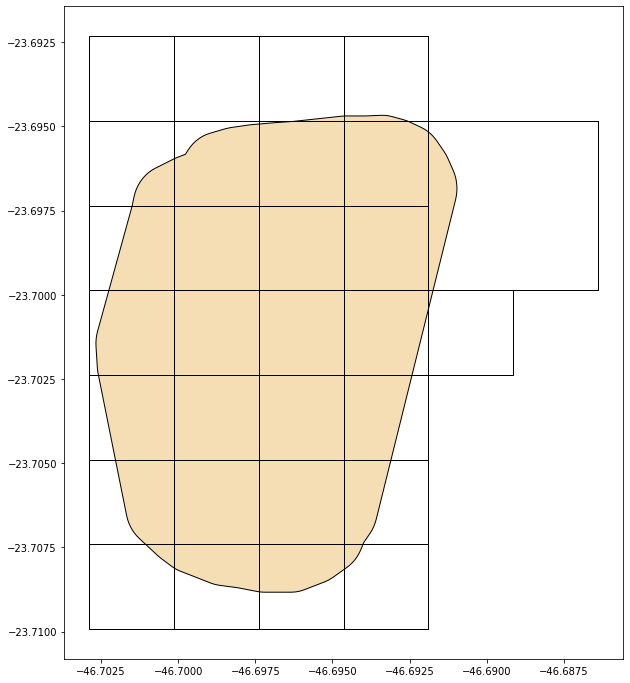

In [83]:
ax = buffer_interlagos.plot(color='wheat', edgecolor='black', figsize=(15,12))
done_gdf.plot(ax=ax, color='none')


In [69]:
import os
dir = '../../../data/Cidade de São Paulo/Interlagos/'

if not os.path.exists(dir): 
    os.makedirs(dir)
#se essa pasta não existir, crio ela

In [70]:
done_gdf.to_file(dir + 'cells_core.geojson')